### Ordinal Regression - binary crossentropy + metrics=['accuracy']
### Correct pixel means

In [1]:
from keras.engine import Model
from keras.layers import Flatten, Dense, Input, Dropout
from keras_vggface.vggface import VGGFace
from keras.preprocessing.image import ImageDataGenerator
from keras_vggface import utils
from keras.optimizers import Adam
from keras.preprocessing import image
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.utils import class_weight
import keras
import numpy as np
import os
import shutil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
%matplotlib inline

/home/gloria/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/gloria/tensorflow/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# Constants
IMG_SIZE = 200

IMG_DIR = '../project/all_females_combined_train_s'
RATING_PATH = '../project/all_females_combined_train_s/train_ratings.txt'

VAL_IMG_DIR = '../project/all_females_combined_val_s'
VAL_RATING_PATH = '../project/all_females_combined_val_s/val_ratings.txt'

VERSION = 'v6-val-2layers'

In [3]:
def getMean(train_data):
    #calculate mean values for pixels (RGB)
    #mean = np.zeros(3)
    data = np.zeros((train_data.shape[0], IMG_SIZE, IMG_SIZE, 3)) 
    for i in range(train_data.shape[0]):#train_data:
        _img = image.load_img(os.path.join(IMG_DIR, train_data[i]), target_size=(IMG_SIZE,IMG_SIZE))
        data[i,:,:,:] = image.img_to_array(_img)
        
        #print(_x.shape)
        #mean[0] += _x[:,:,0].sum() / _x.shape[0] * _x.shape[1] #divide by number of pixels in image
        #mean[1] += _x[:,:,1].sum() / _x.shape[0] * _x.shape[1]
        #mean[2] += _x[:,:,2].sum() / _x.shape[0] * _x.shape[1]
    #divide by number of images
    #print(train_data.shape)
    mean = np.mean(data, axis=(0, 1, 2))
    print(mean)
    #mean = mean / train_data.shape[0]
    return mean

In [4]:
def preprocess(x,mean):
    x[:,:,0] -= mean[0]
    x[:,:,1] -= mean[1]
    x[:,:,2] -= mean[2]

In [5]:
def prepareData(percentage):
    # Load ratings
    ratings = np.genfromtxt(RATING_PATH)
    
    # Convert ratings to the desired format
    # 1. First round them
    ratings_rounded = np.round(ratings, 1).astype(np.int8)

    # 2. Then encode as suggested by Cheng (2007)
    ratings_prepared = np.zeros((len(ratings_rounded), len(np.unique(ratings_rounded))))
    for i, r in enumerate(ratings_rounded):
        for j in range(r):
            ratings_prepared[i, j] = 1
        
    # 3. Finally, make sure assignment is correct
    assert np.all(np.sum(ratings_prepared, axis=1).astype(np.int8) == ratings_rounded)
    
    ### Move all images according to ratings
    images = sorted(os.listdir(IMG_DIR))
    #remove train_ratings.txt from images
    images.remove('train_ratings.txt')
    #convert to np.array for indexing
    images = np.array(images)

    ### Make sure lengths of ratings and images correspond 
    print(len(ratings))
    print(len(images))
    assert len(ratings) == len(images)
    
    perm_ratings = np.random.permutation(len(ratings))
    test_len = int(len(ratings) * percentage/100)
    train_len = len(ratings) - test_len

    test_ind = perm_ratings[:test_len]
    train_ind = perm_ratings[test_len:]
    
    #get test & train data
    data_test = np.zeros((len(test_ind), IMG_SIZE, IMG_SIZE, 3))    
    data_train = np.zeros((len(train_ind), IMG_SIZE, IMG_SIZE, 3)) 
    last_set_train = 0
    last_set_test = 0

    mean = getMean(images[train_ind])
    
    for idx, _im in enumerate(images): #iterate over images
        if idx in test_ind:
            _img = image.load_img(os.path.join(IMG_DIR, _im), target_size=(IMG_SIZE,IMG_SIZE))
            _x = image.img_to_array(_img)
            _x = np.expand_dims(_x, axis=0)
            data_test[last_set_test, :, :, :] = preprocess(_x,mean)#utils.preprocess_input(_x, version=1)# / .255
            last_set_test += 1
        if idx in train_ind:
            _img = image.load_img(os.path.join(IMG_DIR, _im), target_size=(IMG_SIZE,IMG_SIZE))
            _x = image.img_to_array(_img)
            _x = np.expand_dims(_x, axis=0)
            data_train[last_set_train, :, :, :] = preprocess(_x,mean)#utils.preprocess_input(_x, version=1)# / .255
            last_set_train += 1
    
    
    return data_train, ratings_prepared[train_ind], data_test, ratings_prepared[test_ind], ratings_rounded

In [6]:
def getGenerator(data_train, data_test):
    train_datagen = ImageDataGenerator(rescale=1./255, 
                                rotation_range=40,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                shear_range=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                fill_mode='nearest',
                                preprocessing_function=utils.preprocess_input)

    train_datagen.fit(data_train)
    
    
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen.fit(data_test)

    return train_datagen, test_datagen

In [7]:
def visualize_loss(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.figure(figsize=(15,8))
    plt.plot(epochs, loss, 'bo-', label="Training loss")
    plt.plot(epochs, val_loss, 'b', label="Validation loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [8]:
def visualize_acc(history):
    loss = history.history['acc']
    val_loss = history.history['val_acc']
    epochs = range(1, len(loss) + 1)
    plt.figure(figsize=(15,8))
    plt.plot(epochs, loss, 'ro-', label="Training acc")
    plt.plot(epochs, val_loss, 'r', label="Validation acc")
    plt.xlabel('Epochs')
    plt.ylabel('Acc')
    plt.legend()
    plt.show()

In [9]:
def recommend(images, pred_classes):
    recs = np.where(pred_classes >= 4)
    
    for i in recs[0]:
        imgplot = plt.imshow(images[i])
        plt.show()
        plt.clf()

In [10]:
x_train, y_train, x_test, y_test, ratings = prepareData(5)
train_generator, test_generator = getGenerator(x_train,x_test)

print(x_train.shape)
print(x_test.shape)

681
681
[160.5545039  133.45991804 119.8518711 ]
(647, 200, 200, 3)
(34, 200, 200, 3)


In [11]:
# Add custom layers
vgg_base = VGGFace(include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3), pooling='max')
last_layer = vgg_base.get_layer('global_max_pooling2d_1').output
X = Dense(256, activation='relu', name='fc6')(last_layer)
X = Dropout(0.2)(X)
X = Dense(128, activation='relu', name='fc7')(X)
X = Dropout(0.2)(X)
X = Dense(64, activation='relu', name='fc8')(X)
X = Dropout(0.2)(X)
output = Dense(len(np.unique(ratings)), activation='sigmoid')(X)
model = Model(inputs=vgg_base.input, outputs=output)

# Freeze vgg layers
for layer in vgg_base.layers:
    layer.trainable = False
    
# Compute class weights since we have unbalaned classes
class_weight = class_weight.compute_class_weight('balanced', 
                                                 np.unique(ratings), 
                                                 ratings)

model.compile(optimizer=Adam(lr= 0.0005,clipnorm=1.0),
              loss='binary_crossentropy', 
              metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='./weights-' + VERSION + '.hdf5', verbose=1, save_best_only=True)
earlystop = EarlyStopping(monitor='val_loss', patience=10, verbose=0)

In [12]:
history = model.fit_generator(
    train_generator.flow(x_train, y_train, batch_size=64),
    steps_per_epoch=540//64,
    epochs=500,
    class_weight=class_weight,
    validation_data=test_generator.flow(x_test, y_test, batch_size=64),
    callbacks=[earlystop, checkpointer]
)

Epoch 1/500
8/8 [==============================] - 12s 1s/step - loss: 0.6927 - acc: 0.7829 - val_loss: 0.6922 - val_acc: 0.7794

Epoch 00001: val_loss improved from inf to 0.69216, saving model to ./weights-v6-val-2layers.hdf5
Epoch 2/500
8/8 [==============================] - 5s 671ms/step - loss: 0.6916 - acc: 0.7950 - val_loss: 0.6911 - val_acc: 0.7794

Epoch 00002: val_loss improved from 0.69216 to 0.69111, saving model to ./weights-v6-val-2layers.hdf5
Epoch 3/500
8/8 [==============================] - 5s 626ms/step - loss: 0.6904 - acc: 0.7972 - val_loss: 0.6901 - val_acc: 0.7794

Epoch 00003: val_loss improved from 0.69111 to 0.69006, saving model to ./weights-v6-val-2layers.hdf5
Epoch 4/500
8/8 [==============================] - 6s 694ms/step - loss: 0.6893 - acc: 0.8014 - val_loss: 0.6890 - val_acc: 0.7794

Epoch 00004: val_loss improved from 0.69006 to 0.68905, saving model to ./weights-v6-val-2layers.hdf5
Epoch 5/500
8/8 [==============================] - 5s 687ms/step - los

Epoch 36/500
8/8 [==============================] - 5s 630ms/step - loss: 0.6540 - acc: 0.8058 - val_loss: 0.6582 - val_acc: 0.7794

Epoch 00036: val_loss improved from 0.65907 to 0.65820, saving model to ./weights-v6-val-2layers.hdf5
Epoch 37/500
8/8 [==============================] - 5s 628ms/step - loss: 0.6534 - acc: 0.8063 - val_loss: 0.6573 - val_acc: 0.7794

Epoch 00037: val_loss improved from 0.65820 to 0.65731, saving model to ./weights-v6-val-2layers.hdf5
Epoch 38/500
8/8 [==============================] - 5s 616ms/step - loss: 0.6539 - acc: 0.7923 - val_loss: 0.6564 - val_acc: 0.7794

Epoch 00038: val_loss improved from 0.65731 to 0.65644, saving model to ./weights-v6-val-2layers.hdf5
Epoch 39/500
8/8 [==============================] - 5s 685ms/step - loss: 0.6511 - acc: 0.8063 - val_loss: 0.6556 - val_acc: 0.7794

Epoch 00039: val_loss improved from 0.65644 to 0.65557, saving model to ./weights-v6-val-2layers.hdf5
Epoch 40/500
8/8 [==============================] - 5s 669ms

Epoch 71/500
8/8 [==============================] - 5s 615ms/step - loss: 0.6214 - acc: 0.8025 - val_loss: 0.6298 - val_acc: 0.7794

Epoch 00071: val_loss improved from 0.63053 to 0.62983, saving model to ./weights-v6-val-2layers.hdf5
Epoch 72/500
8/8 [==============================] - 6s 688ms/step - loss: 0.6208 - acc: 0.8024 - val_loss: 0.6291 - val_acc: 0.7794

Epoch 00072: val_loss improved from 0.62983 to 0.62912, saving model to ./weights-v6-val-2layers.hdf5
Epoch 73/500
8/8 [==============================] - 5s 676ms/step - loss: 0.6203 - acc: 0.8019 - val_loss: 0.6284 - val_acc: 0.7794

Epoch 00073: val_loss improved from 0.62912 to 0.62839, saving model to ./weights-v6-val-2layers.hdf5
Epoch 74/500
8/8 [==============================] - 5s 622ms/step - loss: 0.6194 - acc: 0.8032 - val_loss: 0.6276 - val_acc: 0.7794

Epoch 00074: val_loss improved from 0.62839 to 0.62764, saving model to ./weights-v6-val-2layers.hdf5
Epoch 75/500
8/8 [==============================] - 5s 616ms

Epoch 106/500
8/8 [==============================] - 5s 623ms/step - loss: 0.5945 - acc: 0.8015 - val_loss: 0.6058 - val_acc: 0.7794

Epoch 00106: val_loss improved from 0.60647 to 0.60583, saving model to ./weights-v6-val-2layers.hdf5
Epoch 107/500
8/8 [==============================] - 5s 619ms/step - loss: 0.5917 - acc: 0.8076 - val_loss: 0.6052 - val_acc: 0.7794

Epoch 00107: val_loss improved from 0.60583 to 0.60519, saving model to ./weights-v6-val-2layers.hdf5
Epoch 108/500
8/8 [==============================] - 5s 616ms/step - loss: 0.5923 - acc: 0.8032 - val_loss: 0.6045 - val_acc: 0.7794

Epoch 00108: val_loss improved from 0.60519 to 0.60454, saving model to ./weights-v6-val-2layers.hdf5
Epoch 109/500
8/8 [==============================] - 5s 687ms/step - loss: 0.5905 - acc: 0.8024 - val_loss: 0.6039 - val_acc: 0.7794

Epoch 00109: val_loss improved from 0.60454 to 0.60390, saving model to ./weights-v6-val-2layers.hdf5
Epoch 110/500
8/8 [==============================] - 5s 

Epoch 141/500
8/8 [==============================] - 5s 614ms/step - loss: 0.5677 - acc: 0.8059 - val_loss: 0.5854 - val_acc: 0.7794

Epoch 00141: val_loss improved from 0.58596 to 0.58544, saving model to ./weights-v6-val-2layers.hdf5
Epoch 142/500
8/8 [==============================] - 5s 687ms/step - loss: 0.5653 - acc: 0.8076 - val_loss: 0.5849 - val_acc: 0.7794

Epoch 00142: val_loss improved from 0.58544 to 0.58493, saving model to ./weights-v6-val-2layers.hdf5
Epoch 143/500
8/8 [==============================] - 5s 630ms/step - loss: 0.5685 - acc: 0.8030 - val_loss: 0.5844 - val_acc: 0.7794

Epoch 00143: val_loss improved from 0.58493 to 0.58440, saving model to ./weights-v6-val-2layers.hdf5
Epoch 144/500
8/8 [==============================] - 5s 621ms/step - loss: 0.5645 - acc: 0.8092 - val_loss: 0.5839 - val_acc: 0.7794

Epoch 00144: val_loss improved from 0.58440 to 0.58386, saving model to ./weights-v6-val-2layers.hdf5
Epoch 145/500
8/8 [==============================] - 5s 

Epoch 176/500
8/8 [==============================] - 6s 689ms/step - loss: 0.5514 - acc: 0.7985 - val_loss: 0.5679 - val_acc: 0.7794

Epoch 00176: val_loss improved from 0.56839 to 0.56793, saving model to ./weights-v6-val-2layers.hdf5
Epoch 177/500
8/8 [==============================] - 5s 686ms/step - loss: 0.5476 - acc: 0.8031 - val_loss: 0.5675 - val_acc: 0.7794

Epoch 00177: val_loss improved from 0.56793 to 0.56747, saving model to ./weights-v6-val-2layers.hdf5
Epoch 178/500
8/8 [==============================] - 5s 596ms/step - loss: 0.5454 - acc: 0.8071 - val_loss: 0.5670 - val_acc: 0.7794

Epoch 00178: val_loss improved from 0.56747 to 0.56701, saving model to ./weights-v6-val-2layers.hdf5
Epoch 179/500
8/8 [==============================] - 5s 646ms/step - loss: 0.5493 - acc: 0.7988 - val_loss: 0.5666 - val_acc: 0.7794

Epoch 00179: val_loss improved from 0.56701 to 0.56656, saving model to ./weights-v6-val-2layers.hdf5
Epoch 180/500
8/8 [==============================] - 6s 

Epoch 211/500
8/8 [==============================] - 5s 617ms/step - loss: 0.5333 - acc: 0.7951 - val_loss: 0.5532 - val_acc: 0.7794

Epoch 00211: val_loss improved from 0.55358 to 0.55322, saving model to ./weights-v6-val-2layers.hdf5
Epoch 212/500
8/8 [==============================] - 5s 624ms/step - loss: 0.5273 - acc: 0.8062 - val_loss: 0.5528 - val_acc: 0.7794

Epoch 00212: val_loss improved from 0.55322 to 0.55285, saving model to ./weights-v6-val-2layers.hdf5
Epoch 213/500
8/8 [==============================] - 5s 623ms/step - loss: 0.5283 - acc: 0.8019 - val_loss: 0.5525 - val_acc: 0.7794

Epoch 00213: val_loss improved from 0.55285 to 0.55252, saving model to ./weights-v6-val-2layers.hdf5
Epoch 214/500
8/8 [==============================] - 5s 684ms/step - loss: 0.5315 - acc: 0.7998 - val_loss: 0.5522 - val_acc: 0.7794

Epoch 00214: val_loss improved from 0.55252 to 0.55215, saving model to ./weights-v6-val-2layers.hdf5
Epoch 215/500
8/8 [==============================] - 4s 

Epoch 246/500
8/8 [==============================] - 5s 624ms/step - loss: 0.5120 - acc: 0.8053 - val_loss: 0.5404 - val_acc: 0.7794

Epoch 00246: val_loss improved from 0.54076 to 0.54042, saving model to ./weights-v6-val-2layers.hdf5
Epoch 247/500
8/8 [==============================] - 5s 617ms/step - loss: 0.5127 - acc: 0.8046 - val_loss: 0.5401 - val_acc: 0.7794

Epoch 00247: val_loss improved from 0.54042 to 0.54010, saving model to ./weights-v6-val-2layers.hdf5
Epoch 248/500
8/8 [==============================] - 5s 685ms/step - loss: 0.5135 - acc: 0.8031 - val_loss: 0.5398 - val_acc: 0.7794

Epoch 00248: val_loss improved from 0.54010 to 0.53978, saving model to ./weights-v6-val-2layers.hdf5
Epoch 249/500
8/8 [==============================] - 5s 629ms/step - loss: 0.5192 - acc: 0.7955 - val_loss: 0.5394 - val_acc: 0.7794

Epoch 00249: val_loss improved from 0.53978 to 0.53941, saving model to ./weights-v6-val-2layers.hdf5
Epoch 250/500
8/8 [==============================] - 6s 

Epoch 281/500
8/8 [==============================] - 5s 620ms/step - loss: 0.5044 - acc: 0.8009 - val_loss: 0.5291 - val_acc: 0.7794

Epoch 00281: val_loss improved from 0.52947 to 0.52914, saving model to ./weights-v6-val-2layers.hdf5
Epoch 282/500
8/8 [==============================] - 5s 622ms/step - loss: 0.5018 - acc: 0.7998 - val_loss: 0.5289 - val_acc: 0.7794

Epoch 00282: val_loss improved from 0.52914 to 0.52888, saving model to ./weights-v6-val-2layers.hdf5
Epoch 283/500
8/8 [==============================] - 5s 621ms/step - loss: 0.5068 - acc: 0.7979 - val_loss: 0.5286 - val_acc: 0.7794

Epoch 00283: val_loss improved from 0.52888 to 0.52858, saving model to ./weights-v6-val-2layers.hdf5
Epoch 284/500
8/8 [==============================] - 5s 619ms/step - loss: 0.4901 - acc: 0.8143 - val_loss: 0.5283 - val_acc: 0.7794

Epoch 00284: val_loss improved from 0.52858 to 0.52828, saving model to ./weights-v6-val-2layers.hdf5
Epoch 285/500
8/8 [==============================] - 5s 

Epoch 316/500
8/8 [==============================] - 6s 690ms/step - loss: 0.4915 - acc: 0.8008 - val_loss: 0.5197 - val_acc: 0.7794

Epoch 00316: val_loss improved from 0.51997 to 0.51971, saving model to ./weights-v6-val-2layers.hdf5
Epoch 317/500
8/8 [==============================] - 5s 657ms/step - loss: 0.4842 - acc: 0.8120 - val_loss: 0.5195 - val_acc: 0.7794

Epoch 00317: val_loss improved from 0.51971 to 0.51945, saving model to ./weights-v6-val-2layers.hdf5
Epoch 318/500
8/8 [==============================] - 5s 620ms/step - loss: 0.4832 - acc: 0.8056 - val_loss: 0.5192 - val_acc: 0.7794

Epoch 00318: val_loss improved from 0.51945 to 0.51917, saving model to ./weights-v6-val-2layers.hdf5
Epoch 319/500
8/8 [==============================] - 5s 626ms/step - loss: 0.4878 - acc: 0.8002 - val_loss: 0.5189 - val_acc: 0.7794

Epoch 00319: val_loss improved from 0.51917 to 0.51892, saving model to ./weights-v6-val-2layers.hdf5
Epoch 320/500
8/8 [==============================] - 5s 

Epoch 351/500
8/8 [==============================] - 6s 697ms/step - loss: 0.4724 - acc: 0.8099 - val_loss: 0.5115 - val_acc: 0.7794

Epoch 00351: val_loss improved from 0.51172 to 0.51149, saving model to ./weights-v6-val-2layers.hdf5
Epoch 352/500
8/8 [==============================] - 5s 645ms/step - loss: 0.4844 - acc: 0.7976 - val_loss: 0.5113 - val_acc: 0.7794

Epoch 00352: val_loss improved from 0.51149 to 0.51125, saving model to ./weights-v6-val-2layers.hdf5
Epoch 353/500
8/8 [==============================] - 6s 706ms/step - loss: 0.4774 - acc: 0.8050 - val_loss: 0.5111 - val_acc: 0.7794

Epoch 00353: val_loss improved from 0.51125 to 0.51106, saving model to ./weights-v6-val-2layers.hdf5
Epoch 354/500
8/8 [==============================] - 5s 633ms/step - loss: 0.4670 - acc: 0.8119 - val_loss: 0.5109 - val_acc: 0.7794

Epoch 00354: val_loss improved from 0.51106 to 0.51085, saving model to ./weights-v6-val-2layers.hdf5
Epoch 355/500
8/8 [==============================] - 5s 

Epoch 386/500
8/8 [==============================] - 6s 758ms/step - loss: 0.4688 - acc: 0.8047 - val_loss: 0.5044 - val_acc: 0.7794

Epoch 00386: val_loss improved from 0.50449 to 0.50435, saving model to ./weights-v6-val-2layers.hdf5
Epoch 387/500
8/8 [==============================] - 5s 685ms/step - loss: 0.4766 - acc: 0.7962 - val_loss: 0.5041 - val_acc: 0.7794

Epoch 00387: val_loss improved from 0.50435 to 0.50415, saving model to ./weights-v6-val-2layers.hdf5
Epoch 388/500
8/8 [==============================] - 6s 741ms/step - loss: 0.4690 - acc: 0.8058 - val_loss: 0.5039 - val_acc: 0.7794

Epoch 00388: val_loss improved from 0.50415 to 0.50394, saving model to ./weights-v6-val-2layers.hdf5
Epoch 389/500
8/8 [==============================] - 5s 682ms/step - loss: 0.4709 - acc: 0.8002 - val_loss: 0.5037 - val_acc: 0.7794

Epoch 00389: val_loss improved from 0.50394 to 0.50372, saving model to ./weights-v6-val-2layers.hdf5
Epoch 390/500
8/8 [==============================] - 6s 

Epoch 421/500
8/8 [==============================] - 6s 709ms/step - loss: 0.4634 - acc: 0.8034 - val_loss: 0.4974 - val_acc: 0.7794

Epoch 00421: val_loss improved from 0.49759 to 0.49736, saving model to ./weights-v6-val-2layers.hdf5
Epoch 422/500
8/8 [==============================] - 6s 708ms/step - loss: 0.4608 - acc: 0.8050 - val_loss: 0.4972 - val_acc: 0.7794

Epoch 00422: val_loss improved from 0.49736 to 0.49718, saving model to ./weights-v6-val-2layers.hdf5
Epoch 423/500
8/8 [==============================] - 5s 616ms/step - loss: 0.4692 - acc: 0.7947 - val_loss: 0.4970 - val_acc: 0.7794

Epoch 00423: val_loss improved from 0.49718 to 0.49701, saving model to ./weights-v6-val-2layers.hdf5
Epoch 424/500
8/8 [==============================] - 5s 646ms/step - loss: 0.4413 - acc: 0.8215 - val_loss: 0.4969 - val_acc: 0.7794

Epoch 00424: val_loss improved from 0.49701 to 0.49685, saving model to ./weights-v6-val-2layers.hdf5
Epoch 425/500
8/8 [==============================] - 6s 

Epoch 456/500
8/8 [==============================] - 5s 660ms/step - loss: 0.4444 - acc: 0.8110 - val_loss: 0.4923 - val_acc: 0.7794

Epoch 00456: val_loss improved from 0.49240 to 0.49226, saving model to ./weights-v6-val-2layers.hdf5
Epoch 457/500
8/8 [==============================] - 6s 721ms/step - loss: 0.4610 - acc: 0.7998 - val_loss: 0.4921 - val_acc: 0.7794

Epoch 00457: val_loss improved from 0.49226 to 0.49214, saving model to ./weights-v6-val-2layers.hdf5
Epoch 458/500
8/8 [==============================] - 5s 658ms/step - loss: 0.4483 - acc: 0.8082 - val_loss: 0.4920 - val_acc: 0.7794

Epoch 00458: val_loss improved from 0.49214 to 0.49202, saving model to ./weights-v6-val-2layers.hdf5
Epoch 459/500
8/8 [==============================] - 5s 657ms/step - loss: 0.4593 - acc: 0.8012 - val_loss: 0.4919 - val_acc: 0.7794

Epoch 00459: val_loss improved from 0.49202 to 0.49193, saving model to ./weights-v6-val-2layers.hdf5
Epoch 460/500
8/8 [==============================] - 5s 

Epoch 491/500
8/8 [==============================] - 5s 627ms/step - loss: 0.4647 - acc: 0.7902 - val_loss: 0.4875 - val_acc: 0.7794

Epoch 00491: val_loss improved from 0.48764 to 0.48750, saving model to ./weights-v6-val-2layers.hdf5
Epoch 492/500
8/8 [==============================] - 5s 621ms/step - loss: 0.4434 - acc: 0.8082 - val_loss: 0.4874 - val_acc: 0.7794

Epoch 00492: val_loss improved from 0.48750 to 0.48739, saving model to ./weights-v6-val-2layers.hdf5
Epoch 493/500
8/8 [==============================] - 5s 686ms/step - loss: 0.4567 - acc: 0.7985 - val_loss: 0.4872 - val_acc: 0.7794

Epoch 00493: val_loss improved from 0.48739 to 0.48722, saving model to ./weights-v6-val-2layers.hdf5
Epoch 494/500
8/8 [==============================] - 5s 622ms/step - loss: 0.4328 - acc: 0.8160 - val_loss: 0.4871 - val_acc: 0.7794

Epoch 00494: val_loss improved from 0.48722 to 0.48713, saving model to ./weights-v6-val-2layers.hdf5
Epoch 495/500
8/8 [==============================] - 5s 

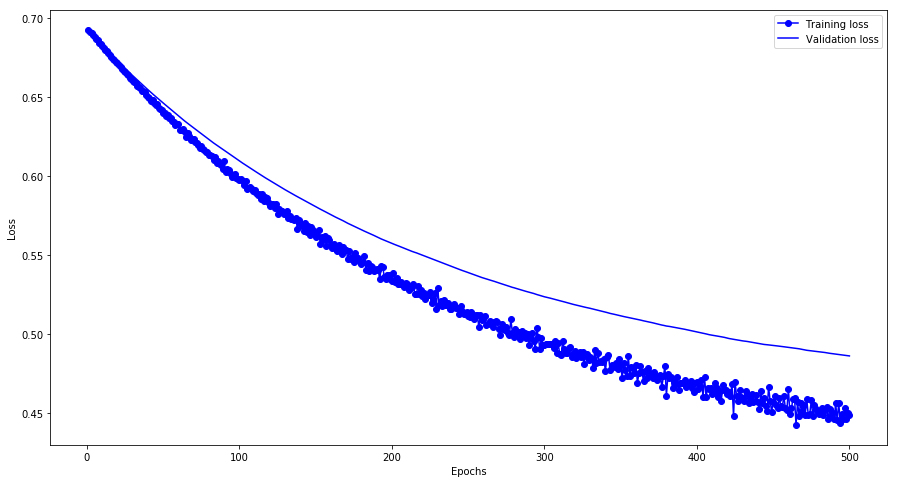

In [13]:
visualize_loss(history)

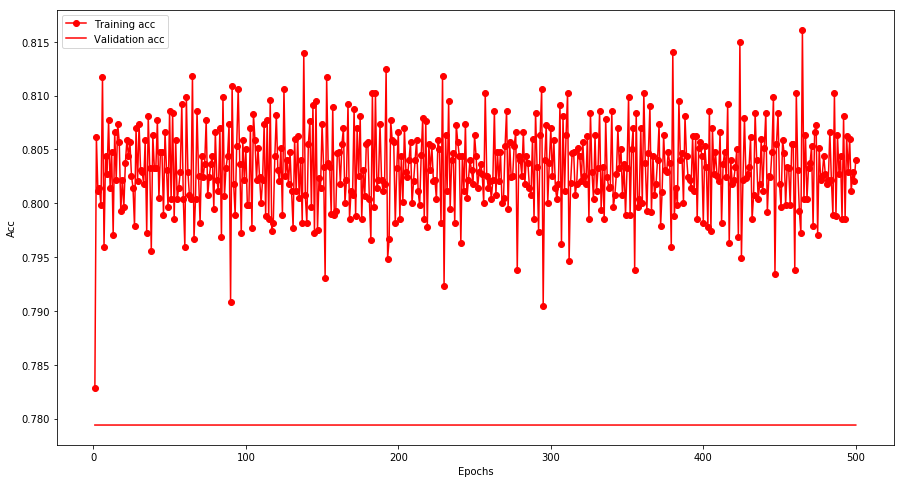

In [14]:
visualize_acc(history)

In [15]:
model.save('./models/love_classifier' + VERSION + '.h5')

In [16]:
predictions = model.predict(x_test)
print(predictions.shape)
pred_classes = predictions.sum(axis=-1)
pred_classes = np.round(pred_classes, 1).astype(np.int8)
print(pred_classes.shape)

y_true = np.array(y_test).sum(axis=-1).astype(np.int8)
print(y_true)
print(pred_classes)

confusion_matrix(y_true,pred_classes)

(34, 6)
(34,)
[2 3 1 5 4 0 1 4 4 1 3 3 4 1 3 2 3 2 1 1 4 2 3 0 4 4 5 0 2 1 2 4 4 4]
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


array([[ 0,  0,  3,  0,  0,  0],
       [ 0,  0,  7,  0,  0,  0],
       [ 0,  0,  6,  0,  0,  0],
       [ 0,  0,  6,  0,  0,  0],
       [ 0,  0, 10,  0,  0,  0],
       [ 0,  0,  2,  0,  0,  0]])

In [17]:
recommend(x_test,pred_classes)

### Validation

In [18]:
def prepareValData():
    # Load ratings
    ratings = np.genfromtxt(VAL_RATING_PATH)
    
    # Convert ratings to the desired format
    # 1. First round them
    ratings_rounded = np.round(ratings, 1).astype(np.int8)

    # 2. Then encode as suggested by Cheng (2007)
    ratings_prepared = np.zeros((len(ratings_rounded), len(np.unique(ratings_rounded))))
    for i, r in enumerate(ratings_rounded):
        for j in range(r):
            ratings_prepared[i, j] = 1
        
    # 3. Finally, make sure assignment is correct
    assert np.all(np.sum(ratings_prepared, axis=1).astype(np.int8) == ratings_rounded)
    
    ### Move all images according to ratings
    images = sorted(os.listdir(VAL_IMG_DIR))
    #remove val_ratings.txt from images
    images.remove('val_ratings.txt')

    ### Make sure lengths of ratings and images correspond 
    assert len(ratings) == len(images)
    
    data = np.zeros((len(images), IMG_SIZE, IMG_SIZE, 3)) 
    last_set = 0
    
    for idx, _im in enumerate(images): #iterate over images
        _img = image.load_img(os.path.join(VAL_IMG_DIR, _im), target_size=(IMG_SIZE,IMG_SIZE))
        _x = image.img_to_array(_img)
        _x = np.expand_dims(_x, axis=0)
        data[last_set, :, :, :] = utils.preprocess_input(_x, version=1) / .255
        last_set += 1
    
    return data, ratings

In [19]:
x_val, ratings_val = prepareValData()

predictions = model.predict(x_val)
pred_classes = predictions.sum(axis=-1)
pred_classes = np.round(pred_classes, 1).astype(np.int8)

y_true = np.array(ratings_val).astype(np.int8)
print(y_true)
print(pred_classes)

confusion_matrix(y_true,pred_classes)

[0 0 0 0 0 0 0 1 1 1 1 1 1 1 2 2 2 2 2 2 2 3 3 3 3 3 3 3 4 4 4 4 4 4 4 5 5]
[5 3 4 4 4 5 5 3 5 5 5 5 4 5 4 4 3 3 3 5 5 4 4 5 4 5 5 4 4 3 3 4 4 5 5 5 5]


array([[0, 0, 0, 1, 3, 3],
       [0, 0, 0, 1, 1, 5],
       [0, 0, 0, 3, 2, 2],
       [0, 0, 0, 0, 4, 3],
       [0, 0, 0, 2, 3, 2],
       [0, 0, 0, 0, 0, 2]])

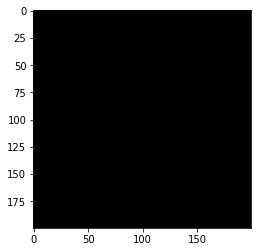

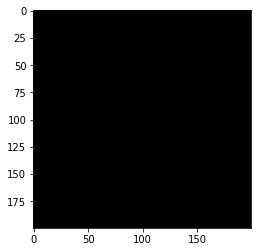

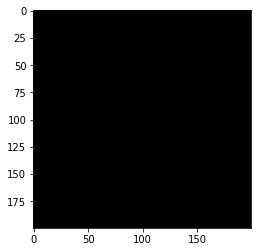

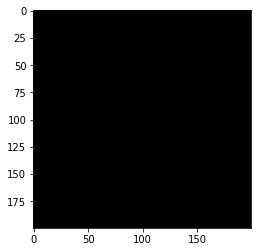

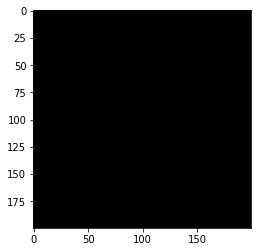

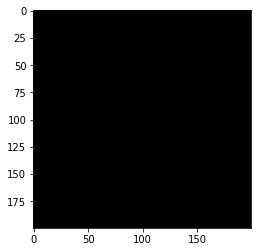

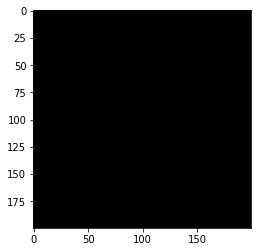

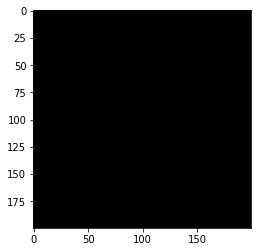

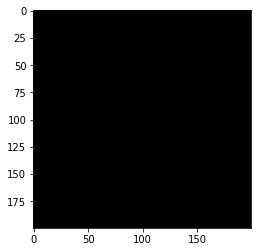

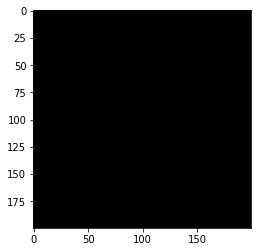

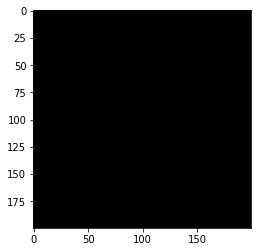

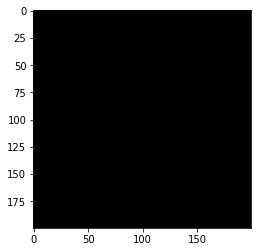

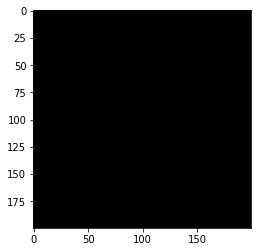

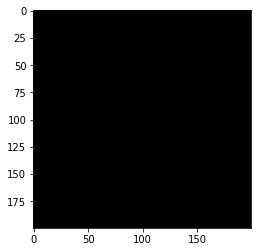

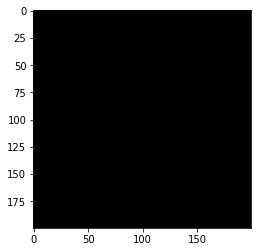

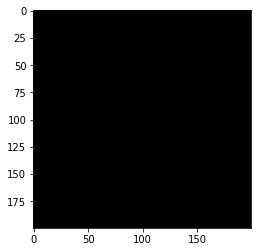

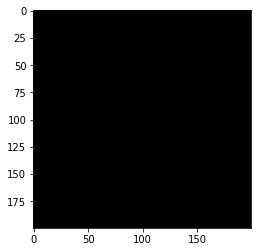

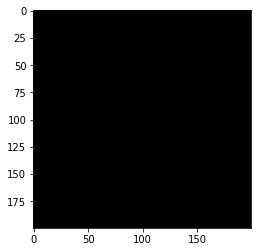

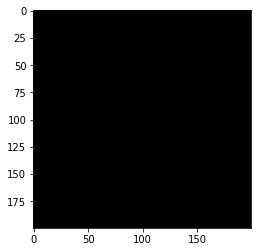

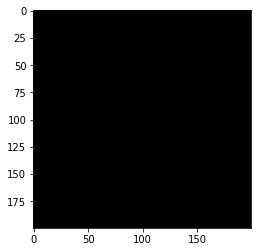

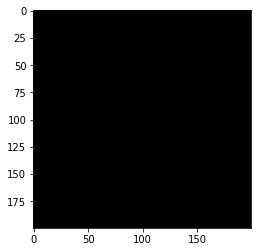

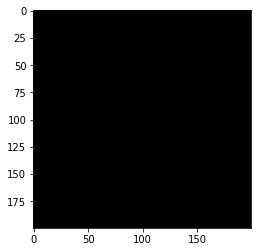

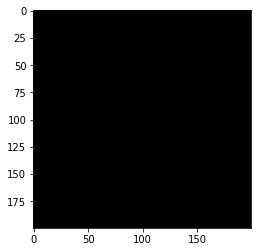

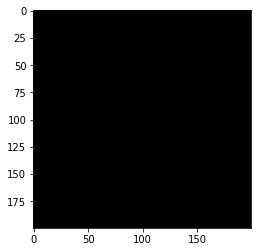

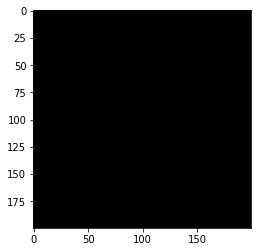

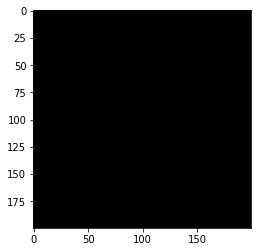

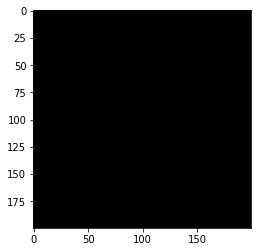

IndexError: index 34 is out of bounds for axis 0 with size 34

In [20]:
recommend(x_test,pred_classes)